<a href="https://colab.research.google.com/github/HexQuant/exx/blob/main/uncertainty_error_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор параметрической неопределённости методами Монте-Карло

Стандарты по оценке неопределённости:
* ГОСТ 34100.3.1-2017
* SO/IEC GUIDE 98-3:2008

In [1]:
# Загрузка нужных библиотек
from scipy import stats, interpolate
import numpy as np
from numpy.random import random
from matplotlib import pyplot as plt 
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [8, 6]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Загрузка данных

In [2]:
# Получение доступа к гугл диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загрузка данных из Экселя
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PKS_OC.xlsx', sheet_name='data')
# Удалить пустые записи
df.dropna(inplace=True)
# Нормализация значения вероятности [0...1]
df['F(x)']=df['F(x)']/df['F(x)'].max()
# Показать несколько первых строк
df.head()

,calc,var,x,F(x)
0,CDF_JNB56_TNFD,Pc(AS),2.001000e-12,0.00
1,CDF_JNB56_TNFD,Pc(AS),1.815000e-11,0.01
2,CDF_JNB56_TNFD,Pc(AS),2.815000e-11,0.02
3,CDF_JNB56_TNFD,Pc(AS),3.711000e-11,0.03
4,CDF_JNB56_TNFD,Pc(AS),4.464000e-11,0.04


In [4]:
# Стоим обратные функции для CDF и заполняем ими хештаблицу хештаблиц
inv_cdf = {}
calc_group = df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  var_dic = {}
  var_group = calc_df.groupby(by=['var'])
  
  for var_name, var_df in var_group:
    # Строим линейную интерполяцию инвертированной CDF. В результате получаем функцию.
    var_dic[var_name] = interpolate.interp1d(var_df['F(x)'],var_df['x'])

  inv_cdf[calc_name] = var_dic

## Определение исследуемых выражений

Формула 1.6.4:
$$t_b = \frac{P_c(AS)}{F_c^{00}-F_c^{01}}$$

In [5]:
def f164(P_cas, F_c00, F_c01):
  a =  F_c00 - F_c01
  #print(a)
  #a = np.where(a > 1e-10, a, 1e-10)
  return  P_cas/(a)

Формула 1.6.5:
$$t_b = \frac{P_c(AS)}{F_c^{00}-F_b^{00}}$$

In [6]:
def f165(P_cas, F_c00, F_b00):
  a =  F_c00 - F_b00
  #print(a)
  #a = np.where(a > 1e-10, a, 1e-10)
  return  P_cas/(a)

## Независимые переменные

In [7]:
# Генерируем случайные значения на оснорве эмперической CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling
# Количество семплов
N=int(1e+6)
samples_df = pd.DataFrame()
for calc_item in inv_cdf.items():
  for var_item in calc_item[1].items():
    # Генерируем N случайных значений (непрерывное равномерное распределение [0...1])
    uniform_samples = random(N)
    #print(calc_item[0])
    #print(var_item[1])
    samples_df = samples_df.append(pd.DataFrame({
        'calc':calc_item[0],
        'var':var_item[0],
        'value':var_item[1](uniform_samples)}))

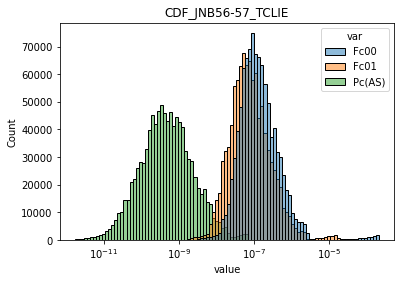

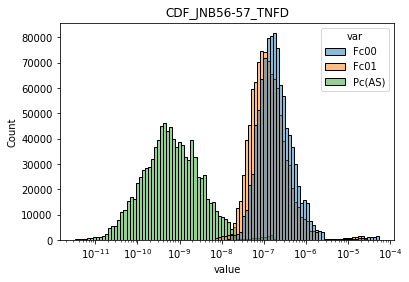

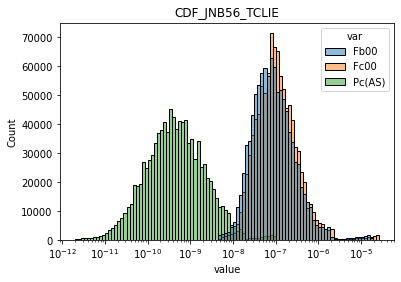

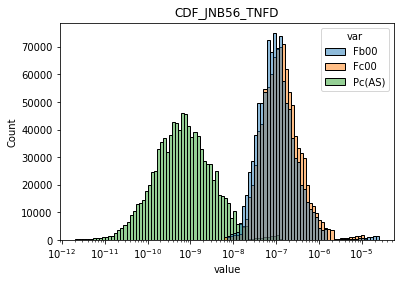

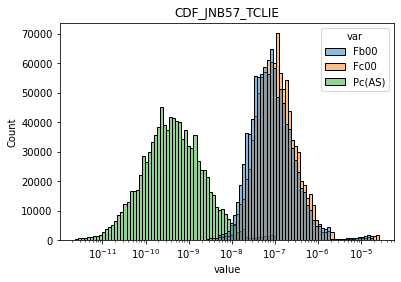

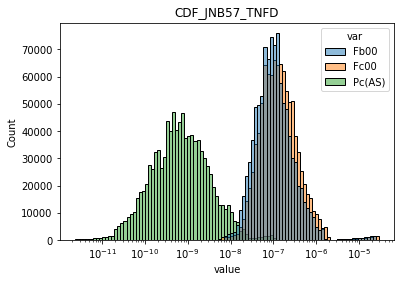

In [8]:
# Строим гитограммы полученных семплов
calc_group = samples_df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  ax = sns.histplot(calc_df,x='value', hue='var', log_scale=True, bins=100)
  ax.set_title(calc_name)
  plt.show()

In [9]:
# Расчёт по формуле 1.6.5
v165 = {}
calc_group = samples_df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  
  if calc_name in ['CDF_JNB56-57_TCLIE', 'CDF_JNB56-57_TNFD']:
    v = f165(calc_df[calc_df['var']=='Pc(AS)']['value'],
                         calc_df[calc_df['var']=='Fc00']['value'],
                         calc_df[calc_df['var']=='Fc01']['value'])
  else:
  
    v = f165(calc_df[calc_df['var']=='Pc(AS)']['value'],
                         calc_df[calc_df['var']=='Fc00']['value'],
                         calc_df[calc_df['var']=='Fb00']['value'])
  
  # Доверительный интервал в %
  ci = 95
  # Порог отсечения
  truncation = 100-ci #99.73 # Отсечение в %, -1.3 соотвествует 3*sigma
  # Значения перцентилей, соответствующие доверительному интервалу 
  p5, p95 = np.percentile(v,[truncation/2, 100 - truncation/2 ])
  # p5, p95 = v165.mean() - 3 * v165.std(), v165.mean() + 3 * v165.std()
  # Откидываем результаты семплирования вне доверительного интервала
  v = v[(v>=p5) & (v<=p95)]
  print(calc_name, f' {ci}% доверительный интервал: [{p5:.2E}, {p95:.2E}] mean={v.mean():.2E}')
  # Сохраняем результаты семплировния для дальнейшего использования
  v165[calc_name] = v

CDF_JNB56-57_TCLIE  95% доверительный интервал: [-0.16670075909165746, 0.22034520013193173] mean=4.41675E-03
CDF_JNB56-57_TNFD  95% доверительный интервал: [-0.17540623348613035, 0.22058622884319773] mean=3.95249E-03
CDF_JNB56_TCLIE  95% доверительный интервал: [-0.19555235134725657, 0.21923144106931522] mean=1.81561E-03
CDF_JNB56_TNFD  95% доверительный интервал: [-0.2485157112009295, 0.27287508135119193] mean=2.49418E-03
CDF_JNB57_TCLIE  95% доверительный интервал: [-0.1906302558959365, 0.2187029354253208] mean=2.14922E-03
CDF_JNB57_TNFD  95% доверительный интервал: [-0.2373965493774472, 0.2634378041878419] mean=2.51510E-03


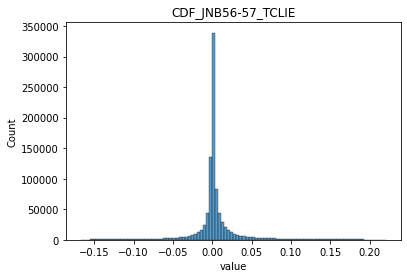

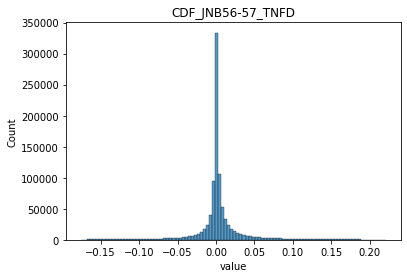

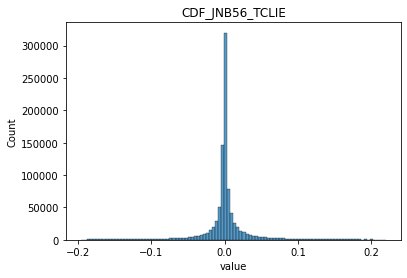

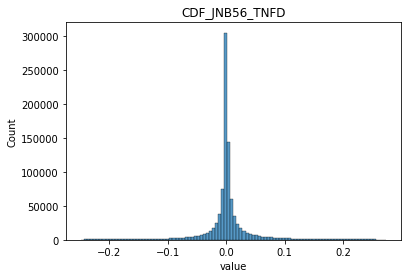

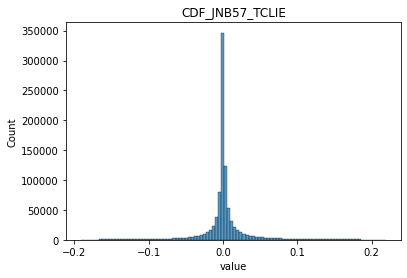

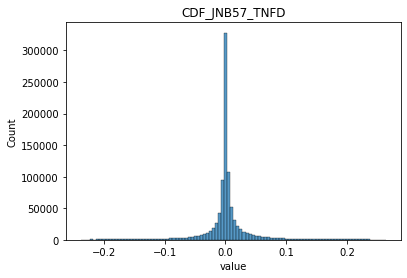

In [10]:
# Выводим результаты семплирвоания
for item in v165.items():
  v = item[1]
  name = item[0]
  ax = sns.histplot(v,bins=100)
  ax.set_title(name)
  #plt.xlim(-3,3)
  #plt.yscale('log')
  plt.show()

In [11]:
#import scipy.stats as st

def fit_scipy_distributions(array, bins, plot_hist = True, plot_best_fit = True, plot_all_fits = False):
  if plot_best_fit or plot_all_fits:
    assert plot_hist, "plot_hist must be True if setting plot_best_fit or plot_all_fits to True"
  
  # Returns un-normalised (i.e. counts) histogram
  y, x = np.histogram(array, bins=bins)
    
  # Some details about the histogram
  bin_width = x[1]-x[0]
  N = len(array)
  x_mid = (x + np.roll(x, -1))[:-1] / 2.0 # go from bin edges to bin middles
  
  # selection of available distributions
  # CHANGE THIS IF REQUIRED
  #DISTRIBUTIONS = [st.alpha,st.cauchy,st.cosine,st.laplace,st.levy,st.levy_l,st.norm]
  DISTRIBUTIONS = [stats.norm, stats.lognorm, stats.laplace, stats.cauchy]
  
  if plot_hist:
      fig, ax = plt.subplots()
      #plt.yscale("log")
      #h = sns.histplot(np.array(array), bins = bins, ax=ax)
      h = ax.hist(array, bins = bins)

  # loop through the distributions and store the sum of squared errors
  # so we know which one eventually will have the best fit
  sses = []
  for dist in DISTRIBUTIONS:
      name = dist.__class__.__name__[:-4]

      params = dist.fit(array)
      arg = params[:-2]
      loc = params[-2]
      scale = params[-1]

      pdf = dist.pdf(x_mid, loc=loc, scale=scale, *arg)
      pdf_scaled = pdf * bin_width * N # to go from pdf back to counts need to un-normalise the pdf

      sse = np.sum((y - pdf_scaled)**2)
      sses.append([sse, name])

      # Not strictly necessary to plot, but pretty patterns
      if plot_all_fits:
          ax.plot(x_mid, pdf_scaled, label = name)
  
  if plot_all_fits:
      plt.legend(loc=1)

  # CHANGE THIS IF REQUIRED
  ax.set_xlabel('x label')
  ax.set_ylabel('y label')

  # Things to return - df of SSE and distribution name, the best distribution and its parameters
  results = pd.DataFrame(sses, columns = ['SSE','distribution']).sort_values(by='SSE') 
  best_name = results.iloc[0]['distribution']
  best_dist = getattr(stats, best_name)
  best_params = best_dist.fit(array)
  
  if plot_best_fit:
      new_x = np.linspace(x_mid[0] - (bin_width * 2), x_mid[-1] + (bin_width * 2), 1000)
      best_pdf = best_dist.pdf(new_x, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
      best_pdf_scaled = best_pdf * bin_width * N
      ax.plot(new_x, best_pdf_scaled, label = best_name)
      plt.legend(loc=1)
  
  if plot_hist:
      plt.show()

    
  return results, best_name, best_params

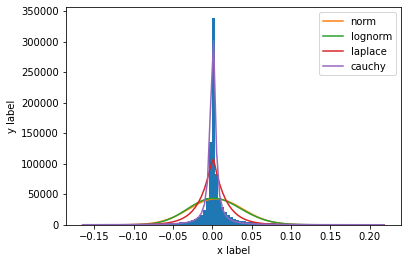

CDF_JNB56-57_TCLIE
            SSE distribution
3  6.994879e+09       cauchy
2  6.169883e+10      laplace
1  1.056970e+11      lognorm
0  1.065185e+11         norm
cauchy (0.0007677884009152263, 0.0036630717933422738)


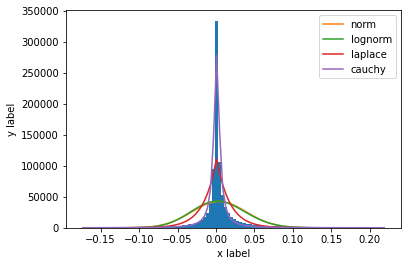

CDF_JNB56-57_TNFD
            SSE distribution
3  9.085387e+09       cauchy
2  5.549816e+10      laplace
1  9.882607e+10      lognorm
0  9.931539e+10         norm
cauchy (0.000909357377616027, 0.004313325286494845)


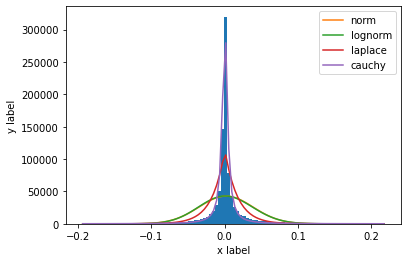

CDF_JNB56_TCLIE
            SSE distribution
3  6.475326e+09       cauchy
2  5.418106e+10      laplace
1  9.663857e+10      lognorm
0  9.674913e+10         norm
cauchy (0.0003424911627621153, 0.004181813334526637)


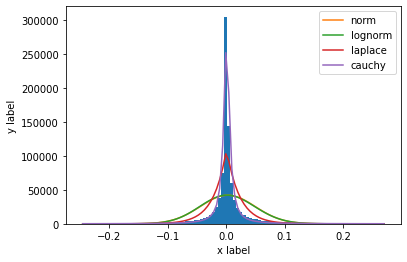

CDF_JNB56_TNFD
            SSE distribution
3  7.799015e+09       cauchy
2  4.870471e+10      laplace
1  8.816811e+10      lognorm
0  8.826545e+10         norm
cauchy (0.0006830310528083956, 0.0058486123138002544)


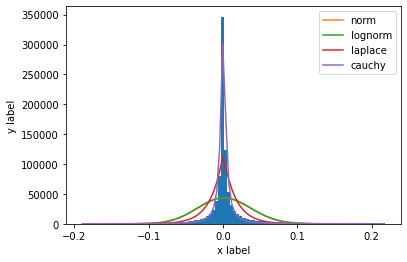

CDF_JNB57_TCLIE
            SSE distribution
3  8.053014e+09       cauchy
2  6.199379e+10      laplace
1  1.077261e+11      lognorm
0  1.079207e+11         norm
cauchy (0.0003957186094661798, 0.003998711073023722)


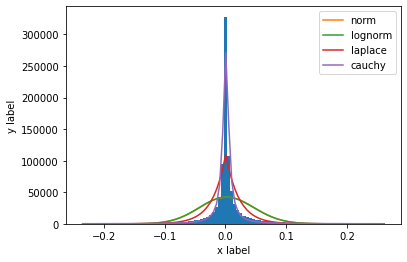

CDF_JNB57_TNFD
            SSE distribution
3  8.833791e+09       cauchy
2  5.342471e+10      laplace
1  9.607933e+10      lognorm
0  9.618370e+10         norm
cauchy (0.0007197189245221714, 0.005565747186925457)


In [12]:
# Подгонка закона распределени под выборку
for v in v165.items():
  if len(v[1])!=0:
    sses, best_name, best_params = fit_scipy_distributions(v[1],
                                                       bins = 100,
                                                       plot_best_fit = False, 
                                                      plot_all_fits=True)
    print(v[0]) 
    print(sses)  
    print(best_name, best_params) 

## Зависимые переменные

In [21]:
# Загрузка данных с корреляциями из Экселя
corr_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PKS_OC.xlsx', sheet_name='corr')
# Удалить пустые записи
corr_df.dropna(inplace=True)
# Показать несколько первых строк
corr_df.head()

,calc,var,corr_group,corr_coef
1,CDF_JNB56_TNFD,Fc00,1.0,0.8
2,CDF_JNB56_TNFD,Fb00,1.0,0.8
4,CDF_JNB56_TCLIE,Fc00,2.0,0.8
5,CDF_JNB56_TCLIE,Fb00,2.0,0.8
7,CDF_JNB57_TNFD,Fc00,3.0,0.8


In [35]:
corr_groups = corr_df.groupby(by='corr_group')
for group in corr_groups:
  print(group[1]['calc'])
# Парное семплрование
#inv_cdf[]

#P_cas = inv_cdf['Pc(AS)'](random(x_unif.shape[0]))
#F_c00 = inv_cdf['Fc00'](x_unif[:,0])
#F_b00= inv_cdf['Fb00'](x_unif[:,1])

N=int(1e+6)
samples_df = pd.DataFrame()
for calc_item in inv_cdf.items():
  if 'Fc00' in calc_item[1] and 'Fc01' in calc_item:
    print(calc_item[1])
  #for var_item in calc_item[1].items():
    # Коэф. корреляции
    k=0.80327
    # Генерируем скорелированную пару нормально распределённых случайных чисел
    mvnorm = stats.multivariate_normal([0, 0], [[1, k], [k, 1]])
    x = mvnorm.rvs((N,))
    # Задаём по данным нормальное распределение
    norm = stats.norm([0],[1])
    # Генерируем N случайных скорелированных значений (непрерывное равномерное распределение [0...1])
    x_unif = norm.cdf(x)
    # Дополнительное правило, отсечения нефизичных значений
    #x_unif = x_unif[x_unif[:,0]>x_unif[:,1]]
    
    samples_df = samples_df.append(pd.DataFrame({
        'calc':calc_item[0],
        'var':'Fc00',
        'value':calc_item[1]['Fc00'] (x_unif)}))
    samples_df = samples_df.append(pd.DataFrame({
        'calc':calc_item[0],
        'var':'Fc01',
        'value':calc_item[1]['Fc01'] (x_unif[1])}))

1    CDF_JNB56_TNFD
2    CDF_JNB56_TNFD
Name: calc, dtype: object
4    CDF_JNB56_TCLIE
5    CDF_JNB56_TCLIE
Name: calc, dtype: object
7    CDF_JNB57_TNFD
8    CDF_JNB57_TNFD
Name: calc, dtype: object
10    CDF_JNB57_TCLIE
11    CDF_JNB57_TCLIE
Name: calc, dtype: object
13    CDF_JNB56-57_TNFD
14    CDF_JNB56-57_TNFD
Name: calc, dtype: object
16    CDF_JNB56-57_TCLIE
17    CDF_JNB56-57_TCLIE
Name: calc, dtype: object


In [ ]:
ax = sns.scatterplot(F_c00,F_b00)
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
sns.histplot([F_c00, F_b00], log_scale=True, bins=50)

In [ ]:
v165_2 = f165(P_cas,F_c00,F_b00)

In [ ]:
print(np.mean(v165), np.mean(v165_2))
sns.histplot((v165, v165_2), bins=50)
plt.yscale('log')

In [ ]:
shape, loc, scale = stats.norm.fit(v165)
x = np.linspace(-10, 10, 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

ax = sns.lineplot(x, pdf)

ax.set_xscale('log')

In [ ]:
sns.scatterplot(x_unif[:,0],x_unif[:,1])

## Черновик

Формла 1.7.7:
$$ {(F}_c^{00}-F_b^{00})\cdot t_{so}+{(P}_c\left(AS\right)-P_b\left(AS\right))+{(F}_c^{01}-F_b^{01})\cdot T_{01}+{(F}_c^{02}-F_b^{02})\cdot T_{02}++{(F}_c^{03}-F_b^{03})\cdot T_{03}+{(P}_c\left(OD\right)-P_b\left(OD\right))+{(F}_c^{05}-F_b^{05})\cdot t_r={P_c\left(AS\right)+(F}_c^{01}-F_b^{00})\cdot T_{01}+{(F}_c^{02}-F_b^{00})\cdot T_{02}+{(F}_c^{03}-F_b^{00})\cdot T_{03}+P_c\left(OD\right)+{(F}_c^{04}-F_b^{00})\cdot t_r+{(F}_c^{09}-F_b^{00})\cdot T_{09}+{(F}_c^{10}-F_b^{00})\cdot T_{10}+{(F}_c^{11}-F_b^{00})\cdot T_{11}+{(F}_c^{12}-F_b^{00})\cdot T_{12}+{(F}_c^{13}-F_b^{00})\cdot T_{13}+{P_c\left(LOCA-JEF\right)}^\ast $$
Выразим из неё $t_{so}$

In [ ]:
from sympy import symbols, IndexedBase, Idx, Sum, Indexed
from sympy import simplify, solve
F_c = IndexedBase('F_c')
F_b = IndexedBase('F_b')
T = IndexedBase('T')
t_so, t_r, P_cas, P_bas, P_cod, P_bod, = symbols('t_{so} t_r P_{c}(AS) P_{b}(AS) P_{c}(OD) P_{b}(OD)')
P_cloca = symbols('P_{c}(LOCA-JEF)')
i, j = symbols('i j')
a = (P_cas-P_bas)+(F_c[1]-F_b[1])*t_so+Sum((F_c[i]-F_b[i])*T[i],(i,0,3))-(P_cod + P_bod)+(F_c[5]-F_b[5]) * t_r
b = P_cas+Sum((F_c[i]-F_b[0])*T[i],(i,0,3))+P_cod+(F_c[4]-F_b[0])*t_r+Sum((F_c[i]-F_b[0])*T[i],(i,9,13))+P_cloca

In [ ]:
a

In [ ]:
b

In [ ]:
solve(a-b, t_so)

$$ t_{so} = \frac{P_b\left(AS\right)+P_b\left(OD\right)+{P_c(LOCA-JEF)}^\ast}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{01})\cdot T_{01}}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{02})\cdot T_{02}}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{03})\cdot T_{03}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{04}-F_b^{00}-F_c^{05}+F_b^{05})\cdot t_r}{F_c^{00}-F_b^{00}} + \frac{(F_c^{09}-F_b^{00})\cdot T_{09}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{10}-F_b^{00})\cdot T_{10}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{11}-F_b^{00})\cdot T_{11}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{11}-F_b^{00})\cdot T_{11}}{F_c^{00}-F_b^{00}}  + \frac{(F_c^{12}-F_b^{00})\cdot T_{12}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{13}-F_b^{00})\cdot T_{13}}{F_c^{00}-F_b^{00}} $$


In [ ]:
def t_so():
    Fb = [uniform.rvs(size=batch_size) for i in range(6)]
    Fc = [uniform.rvs(size=batch_size) for i in range(14)]
    T = [uniform.rvs(size=batch_size) for i in range(14)]
    T = [uniform.rvs(size=batch_size) for i in range(14)]
    Tr = uniform.rvs(size=batch_size)
    
    t =(
        (Fb[0]-Fb[1])*T[1]-
        (Fb[0]-Fb[2])*T[2]-
        (Fb[0]-Fb[3])*T[3]+
        (Fc[4]-Fb[0]-Fc[5]-Fb[5])*Tr+
        (Fc[9]-Fb[0])*T[9]+
        (Fc[10]-Fb[0])*T[10]+
        (Fc[11]-Fb[0])*T[11]+
        (Fc[11]-Fb[0])*T[11]+ # Повторение, описка?
        (Fc[12]-Fb[0])*T[12]+
        (Fc[13]-Fb[0])*T[13]
    )/(Fc[0]-Fb[0])
    return t

$$ F_a^{00}\cdot t_{so}+P_a\left(AS\right)+F_a^{01} \cdot T_{01}+F_a^{02}\cdot T_{02}+F_a^{03}\cdot T_{03}+P_a\left(OD\right)+F_a^{05}\cdot t_r $$

In [ ]:
def f172():
  Fa = [uniform.rvs(size=batch_size) for i in range(6)]
  T = [uniform.rvs(size=batch_size) for i in range(4)]
  t_so = uniform.rvs(size=batch_size)
  tr = uniform.rvs(size=batch_size)
  Pas = uniform.rvs(size=batch_size)
  Pod = uniform.rvs(size=batch_size)
